# Reading IDC DICOM Whole Slide Images with TIAToolbox

<a href="https://colab.research.google.com/github/fedorov/idc-tiatoolbox/blob/main/notebooks/01_reading_idc_slides_with_tiatoolbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Overview

This notebook demonstrates how to:

1. Use `idc-index` to discover and select slide microscopy data from [NCI Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/)
2. Download DICOM WSI files from IDC
3. Open DICOM WSIs using [TIAToolbox](https://tia-toolbox.readthedocs.io/)'s `WSIReader`
4. Extract metadata, generate thumbnails, and read regions at different resolutions
5. Visualize the same slide in the browser using IDC's SLIM viewer

**No GPU required** for this notebook.

## Installation

Run the cell below to install dependencies. **On Colab, the runtime will automatically restart** after installation to pick up the updated numpy version. After the restart, continue from the imports cell below.

In [1]:
%pip install tiatoolbox idc-index openslide-bin "numcodecs<0.16"

# Restart runtime to pick up updated numpy (required on Colab)
import IPython
IPython.Application.instance().kernel.do_shutdown(True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.6/51.6 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━

{'status': 'ok', 'restart': True}

In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from PIL import Image

from idc_index import IDCClient
from tiatoolbox.wsicore.wsireader import WSIReader

## Reproducibility Information

Capture execution timestamp and environment details for reproducibility.

In [2]:
import datetime, os, platform, subprocess, sys
from importlib.metadata import version, PackageNotFoundError

print(f"Executed: {datetime.datetime.now(datetime.timezone.utc).strftime('%Y-%m-%d %H:%M:%S UTC')}")
print(f"Platform: {platform.platform()}")
print(f"Python:   {sys.version}")

# Detect Colab environment and runtime version
try:
    import google.colab  # noqa: F401
    colab_env = "Google Colab"
    # Try to get the Colab runtime version (e.g., "2026.01")
    colab_release = os.environ.get("COLAB_RELEASE_TAG")
    if colab_release:
        colab_env += f" (runtime {colab_release})"
    else:
        # Fall back to google-colab package version as a proxy
        try:
            colab_env += f" (google-colab {version('google-colab')})"
        except PackageNotFoundError:
            pass
    print(f"Runtime:  {colab_env}")
except ImportError:
    print("Runtime:  Local")

print("\nKey package versions:")
for pkg in ["tiatoolbox", "idc-index", "numpy", "matplotlib",
            "openslide-bin", "torch", "highdicom", "wsidicom", "shapely"]:
    try:
        print(f"  {pkg}: {version(pkg)}")
    except PackageNotFoundError:
        pass

try:
    import psutil
    ram = psutil.virtual_memory()
    print(f"\nRAM: {ram.total / (1024**3):.1f} GB total, {ram.available / (1024**3):.1f} GB available")
except ImportError:
    pass

try:
    result = subprocess.run(
        ["nvidia-smi", "--query-gpu=name,memory.total,driver_version", "--format=csv,noheader"],
        capture_output=True, text=True, timeout=5,
    )
    if result.returncode == 0:
        print(f"GPU:  {result.stdout.strip()}")
    else:
        print("GPU:  Not available")
except (FileNotFoundError, subprocess.TimeoutExpired):
    print("GPU:  Not available")

Executed: 2026-02-18 15:57:05 UTC
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
Python:   3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Runtime:  Google Colab (runtime release-colab-external_20260213-060047_RC00)

Key package versions:
  tiatoolbox: 1.6.0
  idc-index: 0.11.9
  numpy: 1.26.4
  matplotlib: 3.9.3
  openslide-bin: 4.0.0.11
  torch: 2.5.1
  wsidicom: 0.22.0
  shapely: 2.0.6

RAM: 12.7 GB total, 11.2 GB available
GPU:  Not available


## 1. Discover Slide Microscopy Data in IDC

IDC provides a specialized `sm_index` table with metadata about slide microscopy (pathology) images, including objective lens power, pixel spacing, and image dimensions. Let's use it to find a manageable slide for this tutorial.

In [3]:
idc_client = IDCClient()
print(f"IDC data version: {idc_client.get_idc_version()}")

# Load the slide microscopy index
idc_client.fetch_index("sm_index")

IDC data version: v23


### How many slide microscopy collections are available?

Let's see which IDC collections contain slide microscopy data and how many slides each has.

In [4]:
sm_collections = idc_client.sql_query("""
    SELECT
        i.collection_id,
        COUNT(DISTINCT i.PatientID) as patients,
        COUNT(DISTINCT s.SeriesInstanceUID) as slides,
        MIN(s.ObjectiveLensPower) as min_power,
        MAX(s.ObjectiveLensPower) as max_power,
        ROUND(SUM(i.series_size_MB), 1) as total_size_mb
    FROM sm_index s
    JOIN index i ON s.SeriesInstanceUID = i.SeriesInstanceUID
    GROUP BY i.collection_id
    ORDER BY slides DESC
""")

print(f"Collections with slide microscopy data: {len(sm_collections)}")
sm_collections.head(20)

Collections with slide microscopy data: 64


collection_id  patients  slides  min_power  max_power  total_size_mb
0           gtex       971   25503         20         20      8554686.4
1       ccdi_mci      4407    4576         20         40      4657163.3
2      tcga_brca      1098    3111         20         40      3438255.3
3      tcga_kirc       537    2173          5         40       831154.0
4       tcga_gbm       607    2053          5         40       655279.4
5      tcga_lusc       504    1612         20         40       625001.9
6      tcga_luad       522    1608         20         40       646275.6
7       tcga_lgg       516    1572          5         40      1194590.0
8        tcga_ov       590    1481         20         40       487918.5
9      tcga_coad       460    1442          5         40       457169.2
10     tcga_ucec       560    1371         20         40      1104341.7
11     tcga_hnsc       523    1263         20         40       573956.3
12          nlst       452    1259         20         40       868284.6
13     tcga_stad       443    1197         20         40       686460.4
14     tcga_prad       500    1172         20         40       610707.1
15     tcga_thca       507    1158         20         40       764981.8
16    cptac_luad       244    1137         20         40       481937.0
17    cptac_lscc       212    1081         20         20       479643.2
18     tcga_skcm       470     950         20         40       738775.7
19     tcga_blca       412     926         20         40       874989.1

### Select a slide from CPTAC-LUAD

We'll pick a slide from the `cptac_luad` (Clinical Proteomic Tumor Analysis Consortium - Lung Adenocarcinoma) collection. We'll look for a 20x slide with a relatively small file size to keep the download quick.

In [5]:
candidates = idc_client.sql_query("""
    SELECT
        i.SeriesInstanceUID,
        i.StudyInstanceUID,
        i.PatientID,
        i.collection_id,
        ROUND(i.series_size_MB, 1) as size_mb,
        s.ObjectiveLensPower,
        s.max_TotalPixelMatrixColumns as width,
        s.max_TotalPixelMatrixRows as height,
        s.min_PixelSpacing_2sf as pixel_spacing_mm,
        i.license_short_name
    FROM sm_index s
    JOIN index i ON s.SeriesInstanceUID = i.SeriesInstanceUID
    WHERE i.collection_id = 'cptac_luad'
        AND s.ObjectiveLensPower = 20
    ORDER BY i.series_size_MB ASC
    LIMIT 10
""")

print("Smallest 20x slides from CPTAC-LUAD:")
candidates

Smallest 20x slides from CPTAC-LUAD:


SeriesInstanceUID  \
0  1.3.6.1.4.1.5962.99.1.260401516.1165064422.164...   
1  1.3.6.1.4.1.5962.99.1.242781647.90340276.16409...   
2  1.3.6.1.4.1.5962.99.1.257806100.1186887886.164...   
3  1.3.6.1.4.1.5962.99.1.249328572.671169429.1640...   
4  1.3.6.1.4.1.5962.99.1.244574402.732178570.1640...   
5  1.3.6.1.4.1.5962.99.1.248010289.792978540.1640...   
6  1.3.6.1.4.1.5962.99.1.256737788.1307158010.164...   
7  1.3.6.1.4.1.5962.99.1.249124585.2139133975.164...   
8  1.3.6.1.4.1.5962.99.1.241886553.875467065.1640...   
9  1.3.6.1.4.1.5962.99.1.252060403.135268892.1640...   

                               StudyInstanceUID  PatientID collection_id  \
0  2.25.252008742885832376522789499109981258409  C3L-03262    cptac_luad   
1   2.25.49695015215998047562303589660250963358  C3N-04330    cptac_luad   
2  2.25.241119208575412892095941144558857582708  C3L-01924    cptac_luad   
3  2.25.252008742885832376522789499109981258409  C3L-03262    cptac_luad   
4  2.25.252008742885832376522789499109981258409  C3L-03262    cptac_luad   
5  2.25.203446203386233251085794784769872344339  C3N-03057    cptac_luad   
6  2.25.241119208575412892095941144558857582708  C3L-01924    cptac_luad   
7  2.25.241119208575412892095941144558857582708  C3L-01924    cptac_luad   
8   2.25.56037080133005148358180034083071142068  C3L-02834    cptac_luad   
9  2.25.252008742885832376522789499109981258409  C3L-03262    cptac_luad   

   size_mb  ObjectiveLensPower  width  height  pixel_spacing_mm  \
0     21.8                  20   9959    9023           0.00049   
1     23.8                  20   9959    9511           0.00049   
2     25.3                  20  12597   20077           0.00032   
3     28.2                  20  11951   13723           0.00049   
4     29.0                  20  11951   12315           0.00049   
5     31.6                  20   9959   10836           0.00049   
6     32.6                  20  15059   20573           0.00032   
7     35.3                  20  19024   22596           0.00032   
8     36.4                  20  13943   14372           0.00049   
9     37.0                  20  13943   12300           0.00049   

  license_short_name  
0          CC BY 3.0  
1          CC BY 3.0  
2          CC BY 3.0  
3          CC BY 3.0  
4          CC BY 3.0  
5          CC BY 3.0  
6          CC BY 3.0  
7          CC BY 3.0  
8          CC BY 3.0  
9          CC BY 3.0

In [6]:
# Select the smallest slide
selected = candidates.iloc[0]
series_uid = selected['SeriesInstanceUID']
study_uid = selected['StudyInstanceUID']

print(f"Selected slide:")
print(f"  Patient: {selected['PatientID']}")
print(f"  Series UID: {series_uid}")
print(f"  Size: {selected['size_mb']} MB")
print(f"  Dimensions: {selected['width']} x {selected['height']} pixels")
print(f"  Objective Power: {selected['ObjectiveLensPower']}x")
print(f"  Pixel Spacing: {selected['pixel_spacing_mm']} mm")
print(f"  License: {selected['license_short_name']}")

Selected slide:
  Patient: C3L-03262
  Series UID: 1.3.6.1.4.1.5962.99.1.260401516.1165064422.1640937941356.2.0
  Size: 21.8 MB
  Dimensions: 9959 x 9023 pixels
  Objective Power: 20x
  Pixel Spacing: 0.00049 mm
  License: CC BY 3.0


## 2. Download the DICOM WSI from IDC

IDC stores pathology images as DICOM Slide Microscopy (SM) objects. Each slide is a DICOM Series containing multiple `.dcm` files (one per pyramid level/frame). We'll download into a folder named by the SeriesInstanceUID.

In [7]:
download_dir = './slides'
os.makedirs(download_dir, exist_ok=True)

idc_client.download_from_selection(
    downloadDir=download_dir,
    seriesInstanceUID=[series_uid],
    dirTemplate='%SeriesInstanceUID'
)

slide_path = os.path.join(download_dir, series_uid)
dcm_files = [f for f in os.listdir(slide_path) if f.endswith('.dcm')]
print(f"Downloaded {len(dcm_files)} DICOM files to {slide_path}")

Downloaded 5 DICOM files to ./slides/1.3.6.1.4.1.5962.99.1.260401516.1165064422.1640937941356.2.0


## 3. Open the Slide with TIAToolbox

TIAToolbox's `WSIReader.open()` automatically detects DICOM WSI directories and returns a `DICOMWSIReader`. This provides a unified API for reading slides regardless of the underlying format (DICOM, SVS, NDPI, etc.).

In [8]:
reader = WSIReader.open(slide_path)

print(f"Reader type: {type(reader).__name__}")
print(f"\nSlide metadata:")

info = reader.info

# DICOMWSIReader may not populate objective_power or mpp from DICOM metadata.
# We can fill them in from the IDC sm_index query results.
if info.objective_power is None:
    info.objective_power = float(selected['ObjectiveLensPower'])
    print(f"  (objective_power set from IDC metadata)")

if info.mpp is None:
    # pixel_spacing_mm from sm_index is in mm; convert to microns
    pixel_spacing_um = float(selected['pixel_spacing_mm']) * 1000
    info.mpp = np.array([pixel_spacing_um, pixel_spacing_um])
    print(f"  (mpp set from IDC pixel spacing)")

print(f"  Slide dimensions (w x h): {info.slide_dimensions}")
print(f"  Objective power: {info.objective_power}")
print(f"  MPP (microns per pixel): {info.mpp}")
print(f"  Number of levels: {len(info.level_dimensions)}")
print(f"  Level dimensions: {info.level_dimensions}")
print(f"  Level downsamples: {info.level_downsamples}")
print(f"  Vendor: {info.vendor}")

Reader type: DICOMWSIReader

Slide metadata:
  (objective_power set from IDC metadata)
  Slide dimensions (w x h): (9959, 9023)
  Objective power: 20.0
  MPP (microns per pixel): [0.4942 0.4942]
  Number of levels: 2
  Level dimensions: ((9959, 9023), (2489, 2255))
  Level downsamples: [1.0, 4.001267840137403]
  Vendor: Leica Biosystems


## 4. Generate a Slide Thumbnail

A thumbnail gives us a quick overview of the entire slide. TIAToolbox can generate thumbnails at any target resolution.

Thumbnail shape: (564, 622, 3)


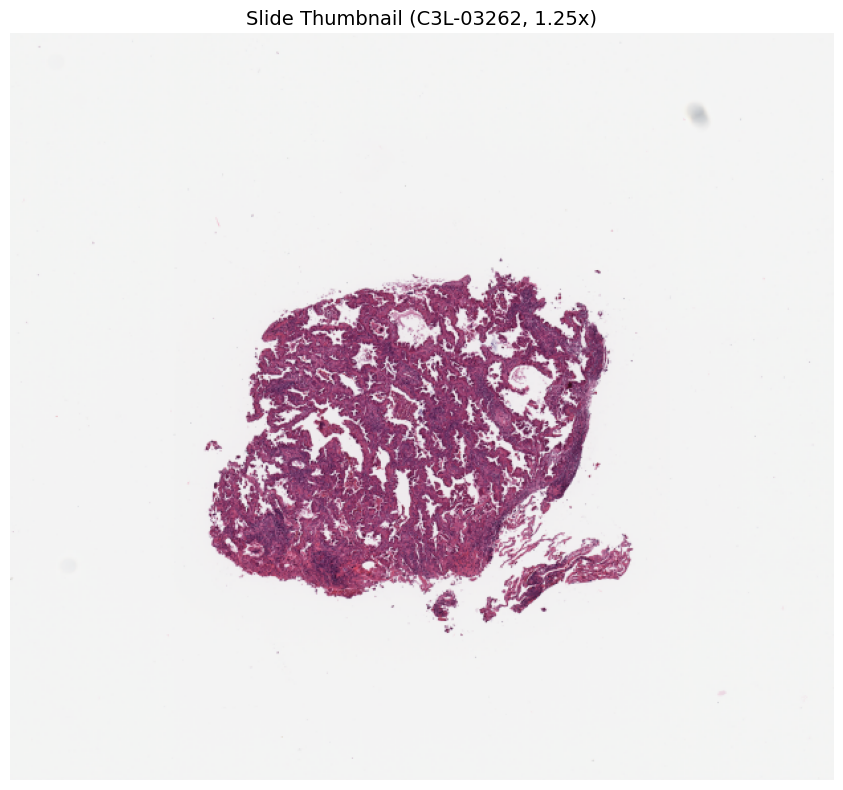

In [9]:
# Generate thumbnail at 1.25x magnification
thumbnail = reader.slide_thumbnail(resolution=1.25, units="power")

print(f"Thumbnail shape: {thumbnail.shape}")

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(thumbnail)
ax.set_title(f"Slide Thumbnail ({selected['PatientID']}, 1.25x)", fontsize=14)
ax.axis('off')
plt.tight_layout()
plt.show()

## 5. Read Regions at Different Resolutions

TIAToolbox provides two main methods for reading regions:

- **`read_bounds(bounds, resolution, units)`**: Reads a region defined by a bounding box in **baseline coordinates** (left, top, right, bottom) and returns it at the requested resolution. The output pixel dimensions change with resolution.
- **`read_rect(location, size, resolution, units)`**: Reads a fixed-size patch at the requested resolution. The location is in baseline coordinates by default.

Both support multiple resolution unit systems:
- **`units="power"`**: Magnification (e.g., 5x, 10x, 20x)
- **`units="mpp"`**: Microns per pixel (e.g., 0.5 mpp)
- **`units="level"`**: Pyramid level directly (0 = highest resolution)

**Note on DICOMWSIReader:** The current `DICOMWSIReader` (via `wsidicom`) has a coordinate handling issue when reading at resolutions that map to non-baseline pyramid levels — baseline coordinates are passed unscaled, causing out-of-bounds errors. A reliable workaround is to read at native resolution and resize, which we demonstrate below.

### Same region at different magnifications

In [10]:
# Pick a location in the tissue area
# We'll find a tissue-rich region by looking at the thumbnail
thumb_gray = np.mean(thumbnail, axis=2)
tissue_mask = thumb_gray < 200  # Simple threshold to find tissue

# Find the center of mass of tissue
tissue_coords = np.argwhere(tissue_mask)
if len(tissue_coords) > 0:
    center_y, center_x = tissue_coords.mean(axis=0).astype(int)
else:
    center_y, center_x = thumbnail.shape[0] // 2, thumbnail.shape[1] // 2

# Scale from thumbnail coordinates to baseline (full resolution) coordinates
thumb_scale_x = info.slide_dimensions[0] / thumbnail.shape[1]
thumb_scale_y = info.slide_dimensions[1] / thumbnail.shape[0]
baseline_x = int(center_x * thumb_scale_x)
baseline_y = int(center_y * thumb_scale_y)

print(f"Tissue center at thumbnail coords: ({center_x}, {center_y})")
print(f"Tissue center at baseline coords: ({baseline_x}, {baseline_y})")

Tissue center at thumbnail coords: (304, 311)
Tissue center at baseline coords: (4867, 4975)


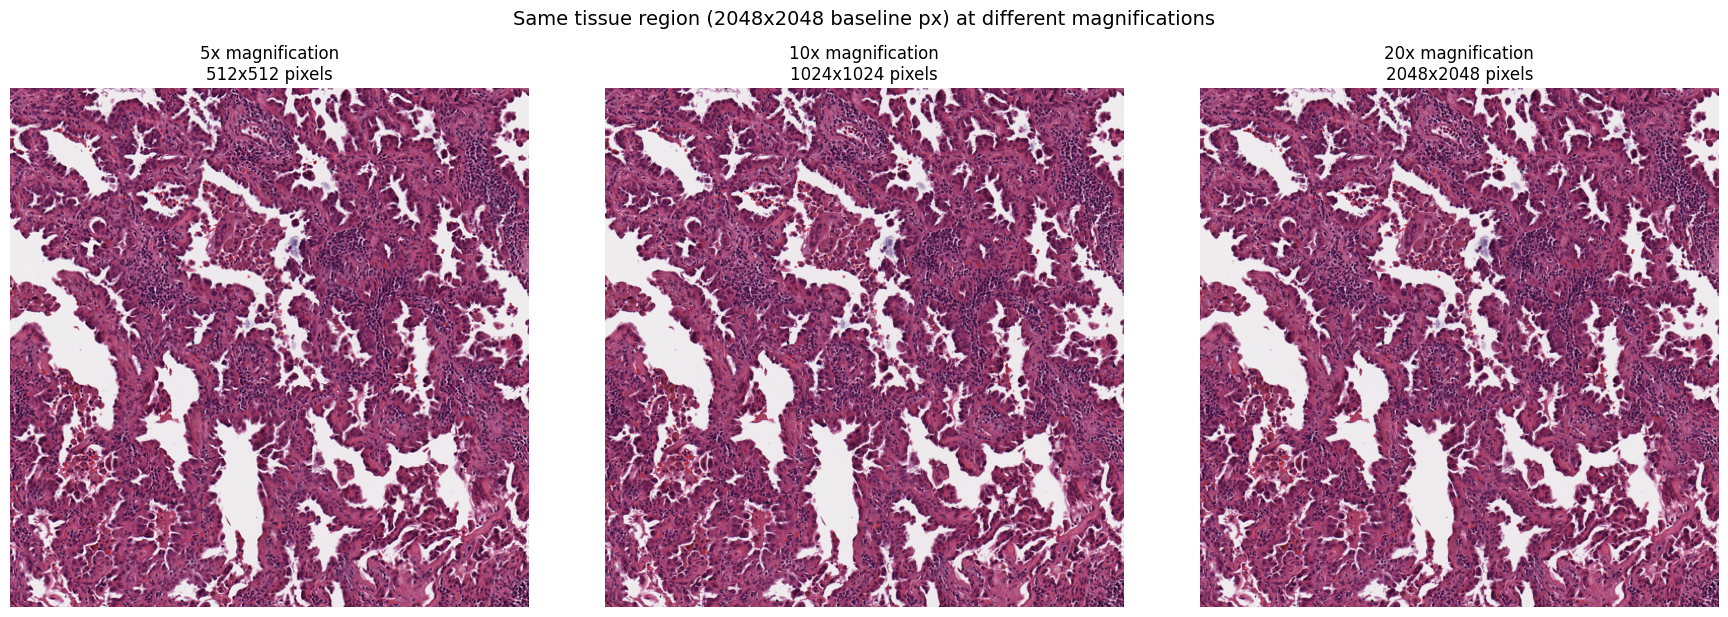

In [11]:
# Define a region in baseline coordinates centered on the tissue
region_size = 2048  # baseline pixels
bounds = (
    max(0, baseline_x - region_size // 2),
    max(0, baseline_y - region_size // 2),
    min(info.slide_dimensions[0], baseline_x + region_size // 2),
    min(info.slide_dimensions[1], baseline_y + region_size // 2),
)

# Read the region at native resolution, then resize to show different magnifications
region_native = reader.read_bounds(
    bounds=bounds,
    resolution=info.objective_power,
    units="power",
)

powers = [5, 10, 20]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, power in zip(axes, powers):
    scale = power / info.objective_power
    if scale < 1:
        new_w = int(region_native.shape[1] * scale)
        new_h = int(region_native.shape[0] * scale)
        region = np.array(Image.fromarray(region_native).resize((new_w, new_h), Image.LANCZOS))
    else:
        region = region_native

    ax.imshow(region)
    ax.set_title(f"{power}x magnification\n{region.shape[1]}x{region.shape[0]} pixels", fontsize=12)
    ax.axis('off')

plt.suptitle(f"Same tissue region ({region_size}x{region_size} baseline px) at different magnifications", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Same region at different microns per pixel (mpp)

Microns per pixel is often the preferred unit in computational pathology because it's independent of the scanner's objective lens.

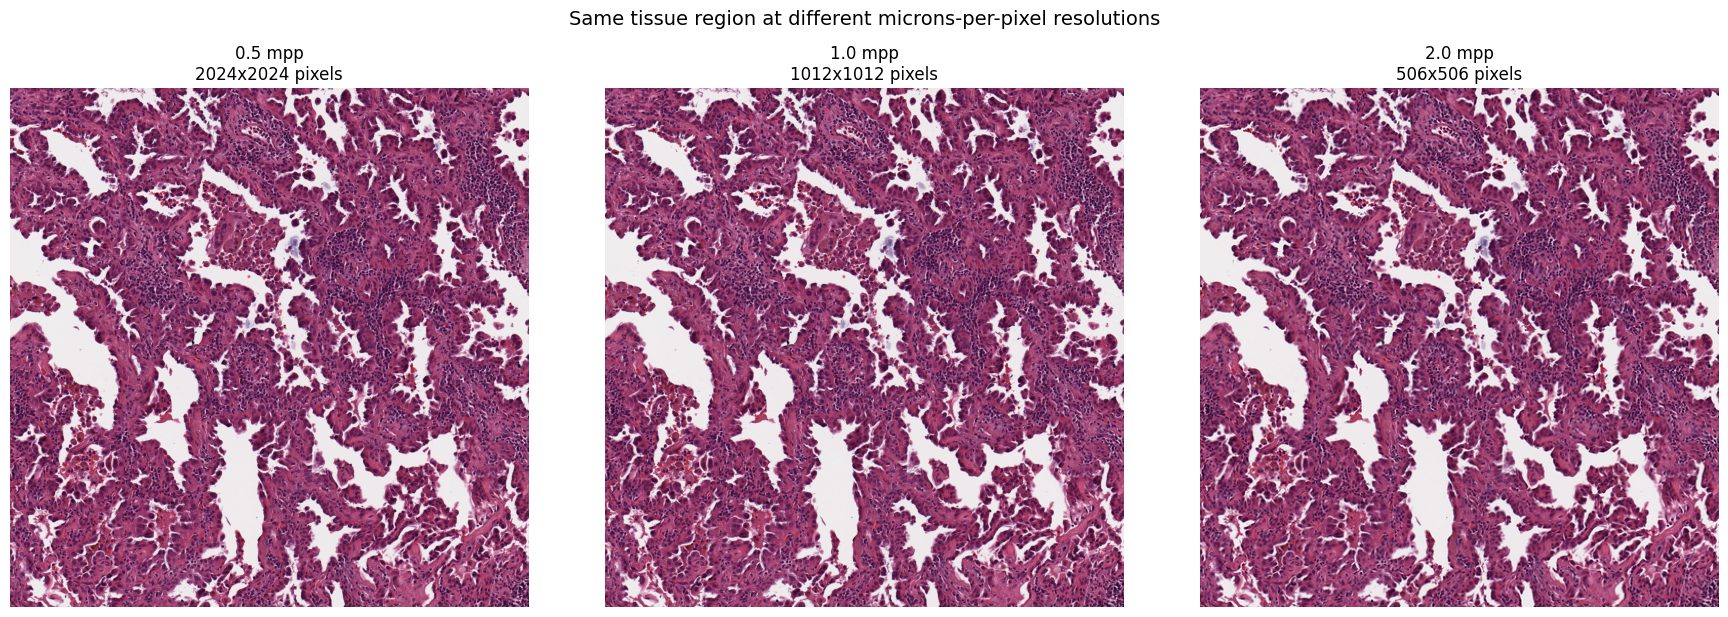

In [12]:
# Same region at different microns-per-pixel resolutions
mpp_values = [0.5, 1.0, 2.0]
native_mpp = float(info.mpp[0])

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, mpp in zip(axes, mpp_values):
    scale = native_mpp / mpp
    if scale < 1:
        new_w = int(region_native.shape[1] * scale)
        new_h = int(region_native.shape[0] * scale)
        region = np.array(Image.fromarray(region_native).resize((new_w, new_h), Image.LANCZOS))
    else:
        region = region_native

    ax.imshow(region)
    ax.set_title(f"{mpp} mpp\n{region.shape[1]}x{region.shape[0]} pixels", fontsize=12)
    ax.axis('off')

plt.suptitle(f"Same tissue region at different microns-per-pixel resolutions", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### Reading a fixed-size patch with `read_rect()`

`read_rect()` reads a patch of a given pixel size at the requested resolution. The `location` is the top-left corner in baseline coordinates. This is useful when you need fixed-size patches (e.g., 256x256 or 512x512) for model input.

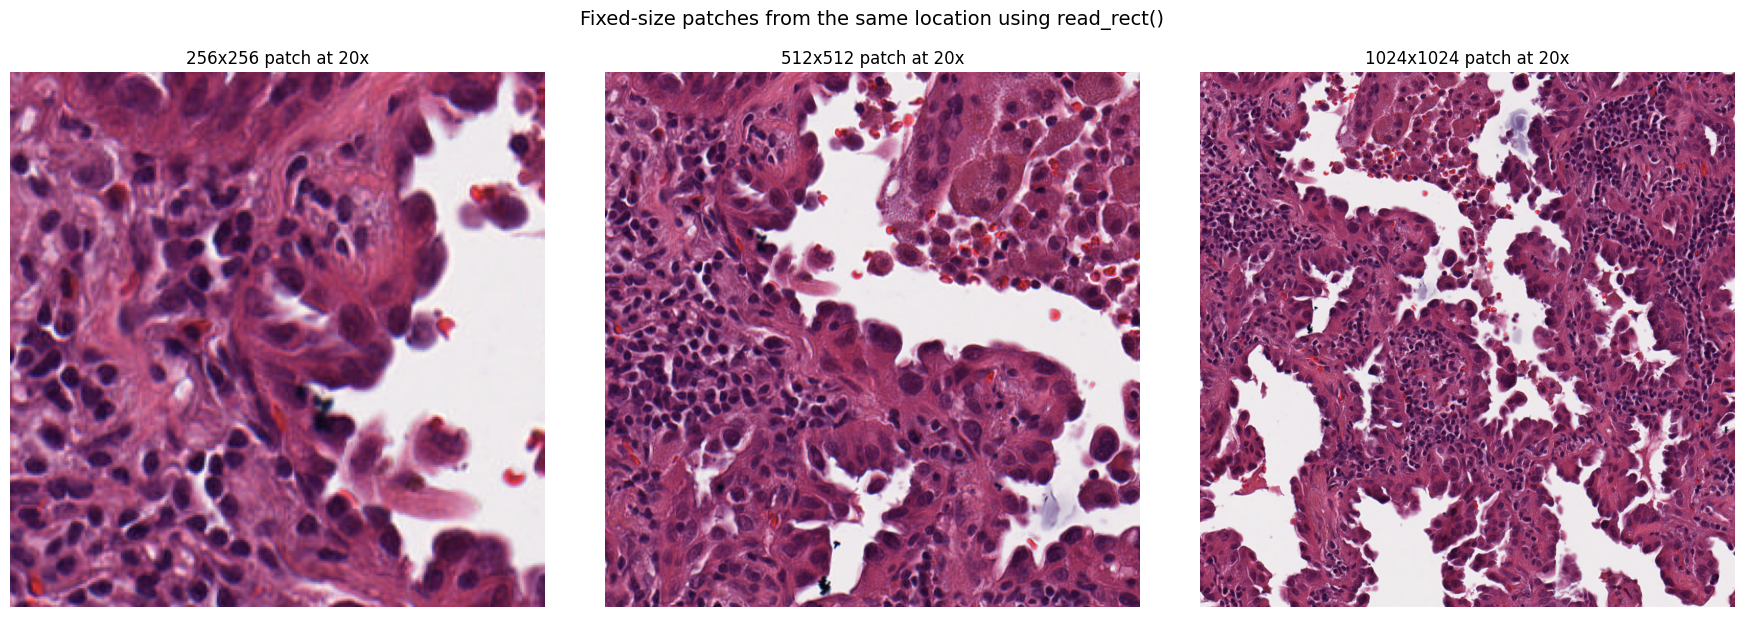

In [13]:
# Read fixed-size patches at the native resolution using read_rect()
# Location is the top-left corner; coord_space="resolution" means coordinates
# are in the target resolution's pixel space (at native power, same as baseline)
native_power = int(info.objective_power)

# Ensure location is within bounds
loc_x = max(0, baseline_x - 512)
loc_y = max(0, baseline_y - 512)

patch_sizes = [256, 512, 1024]
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, size in zip(axes, patch_sizes):
    patch = reader.read_rect(
        location=(loc_x, loc_y),
        size=(size, size),
        resolution=native_power,
        units="power",
        coord_space="resolution",
    )

    ax.imshow(patch)
    ax.set_title(f"{size}x{size} patch at {native_power}x", fontsize=12)
    ax.axis('off')

plt.suptitle("Fixed-size patches from the same location using read_rect()", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Visualize in the SLIM Viewer

IDC provides a browser-based slide viewer ([SLIM](https://github.com/ImagingDataCommons/slim)) that lets you explore the same slide interactively without any local software. This is useful for verifying what you see programmatically.

In [14]:
viewer_url = idc_client.get_viewer_URL(
    seriesInstanceUID=series_uid
)

print(f"View this slide in SLIM viewer:")
print(viewer_url)

View this slide in SLIM viewer:
https://viewer.imaging.datacommons.cancer.gov/slim/studies/2.25.252008742885832376522789499109981258409/series/1.3.6.1.4.1.5962.99.1.260401516.1165064422.1640937941356.2.0


## 7. Explore Slide Metadata in Detail

Let's look at the full metadata dictionary available from TIAToolbox's reader.

In [15]:
info_dict = reader.info.as_dict()
for key, value in info_dict.items():
    print(f"  {key}: {value}")

  objective_power: 20.0
  slide_dimensions: (9959, 9023)
  level_count: 2
  level_dimensions: ((9959, 9023), (2489, 2255))
  level_downsamples: [1.0, 4.001267840137403]
  vendor: Leica Biosystems
  mpp: (0.4942, 0.4942)
  file_path: None
  axes: YXS


## Summary

In this notebook, we learned how to:

- Use `idc-index` with `sm_index` to discover and select slide microscopy data from IDC
- Download DICOM WSI files using `download_from_selection()` with `dirTemplate='%SeriesInstanceUID'`
- Open DICOM slides with `WSIReader.open()`, which automatically detects the format and returns a `DICOMWSIReader`
- Read metadata including dimensions, magnification, and microns-per-pixel
- Generate thumbnails and read regions using different resolution units (`power`, `mpp`)
- Use `read_rect()` for location+size based reading and `read_bounds()` for bounding-box based reading
- Get a SLIM viewer URL for interactive browser-based visualization

**Next:** [Notebook 02](02_tissue_masking_and_patch_extraction.ipynb) covers tissue detection and patch extraction from IDC slides.

## Acknowledgments

- **IDC:** Fedorov, A., et al. "National Cancer Institute Imaging Data Commons: Toward Transparency, Reproducibility, and Scalability in Imaging Artificial Intelligence." *RadioGraphics* 43.12 (2023). https://doi.org/10.1148/rg.230180
- **TIAToolbox:** Pocock, J., et al. "TIAToolbox as an end-to-end library for advanced tissue image analytics." *Communications Medicine* 2, 120 (2022). https://doi.org/10.1038/s43856-022-00186-5